# Creating a Synthetic Model 

✅ Data saved successfully to:
C:\Users\sadra\outputs\six_layer_model.txt


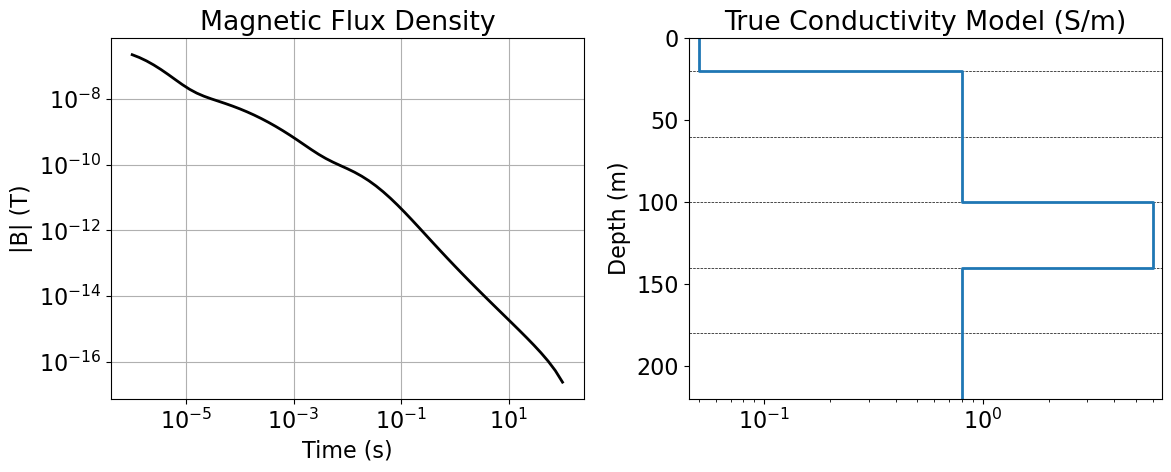

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt

from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG.utils import plot_1d_layer_model
output_dir = r"C:\Users\sadra\outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

source_location = np.array([0.0, 0.0, 0.5])
source_orientation = "z"
current_amplitude = 10.0
source_radius = 15.0

receiver_location = np.array([0.0, 0.0, 0.5])
receiver_orientation = "z"
times = np.logspace(-6, 2, 61)

receiver_list = [
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
]

waveform = tdem.sources.StepOffWaveform()

source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=current_amplitude,
        radius=source_radius
    )
]

survey = tdem.Survey(source_list)
thicknesses = np.array([20.0, 40.0, 40.0, 40.0, 40.0])
n_layer = len(thicknesses) + 1  # = 6 layers total

sigma_model = np.zeros(n_layer)
sigma_model[0] = 0.05  # Layer 1: thin weakly conductive
sigma_model[1] = 0.8   # Layer 2: moderate
sigma_model[2] = 0.8   # Layer 3: moderate
sigma_model[3] = 6.0   # Layer 4: highly conductive
sigma_model[4] = 0.8   # Layer 5: moderate
sigma_model[5] = 0.8   # Layer 6: moderate basement
model_mapping = maps.IdentityMap(nP=n_layer)

simulation_conductive = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping
)
dpred_conductive = simulation_conductive.dpred(sigma_model)
np.random.seed(347)
noise = 0.00 * np.abs(dpred_conductive) * np.random.rand(len(dpred_conductive))
dpred_noisy = dpred_conductive + noise

output_file = os.path.join(output_dir, "six_layer_model.txt")
np.savetxt(output_file, np.c_[times, dpred_noisy], fmt="%.4e", header="TIME BZ")

print(f"✅ Data saved successfully to:\n{output_file}")
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.loglog(times, np.abs(dpred_conductive), "k", lw=2)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("|B| (T)")
ax1.set_title("Magnetic Flux Density")
ax1.grid(True, which="both")
ax2 = fig.add_subplot(1, 2, 2)
plot_1d_layer_model(thicknesses, sigma_model, ax=ax2, show_layers=True)
ax2.set_title("True Conductivity Model (S/m)")

plt.tight_layout()
plt.show()


# Plotting Observed Data

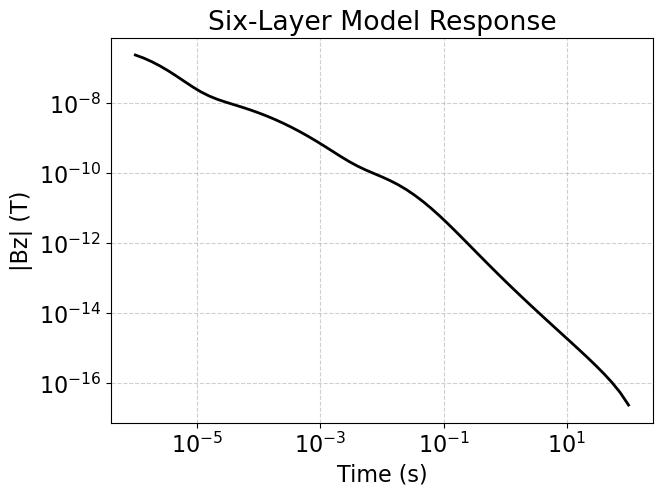

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load the saved file ---
file_path = "six_layer_model.txt"  
data = np.loadtxt(file_path, comments="#")
times = data[:, 0]
bz = data[:, 1]
plt.figure(figsize=(7, 5))
plt.loglog(times, np.abs(bz), 'k-', lw=2)
plt.xlabel("Time (s)")
plt.ylabel("|Bz| (T)")
plt.title("Six-Layer Model Response")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.show()

# Scenario 1: Inversion with $L_p = 0,L_q = 2$

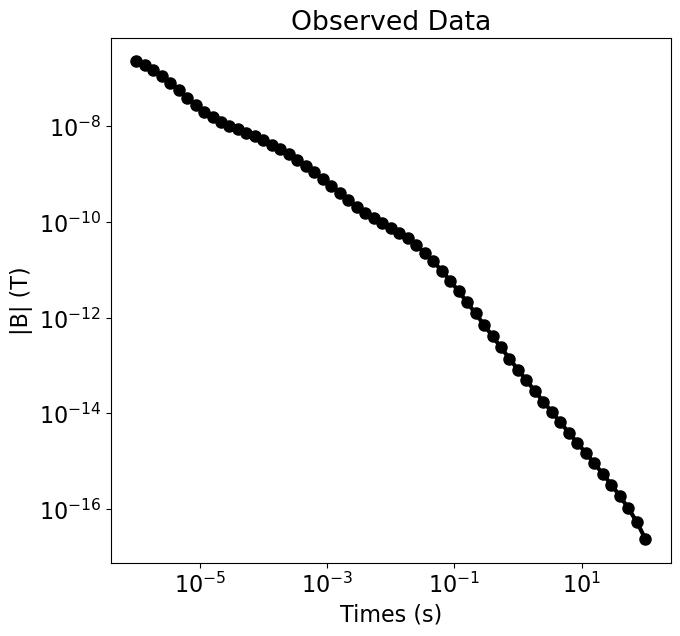

Starting conductivity: 0.5 S/m

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        


C:\Users\sadra\AppData\Local\Temp\ipykernel_5908\1631213734.py:91: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  reg.mref = starting_model


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.27e+06  7.60e+05  0.00e+00  7.60e+05    1.30e+06      0              
   1  6.33e+05  6.46e+05  4.39e-02  6.73e+05    5.32e+05      0              
   2  1.58e+05  5.68e+05  1.38e-01  5.90e+05    7.39e+05      0   Skip BFGS  
   3  7.91e+04  3.36e+05  1.02e+00  4.17e+05    2.66e+05      0              
   4  1.98e+04  2.33e+05  2.05e+00  2.74e+05    3.23e+05      0   Skip BFGS  
   5  9.88e+03  8.27e+04  6.32e+00  1.45e+05    7.11e+04      0              
   6  2.47e+03  4.35e+04  9.16e+00  6.61e+04    8.20e+04      0   Skip BFGS  
   7  1.24e+03  1.14e+04  1.61e+01  3.14e+04    1.66e+04      0              
   8  3.09e+02  5.02e+03  1.94e+01  1.10e+04    1.69e+04      0   Skip BFGS  
   9  1.54e+02  9.71e+02

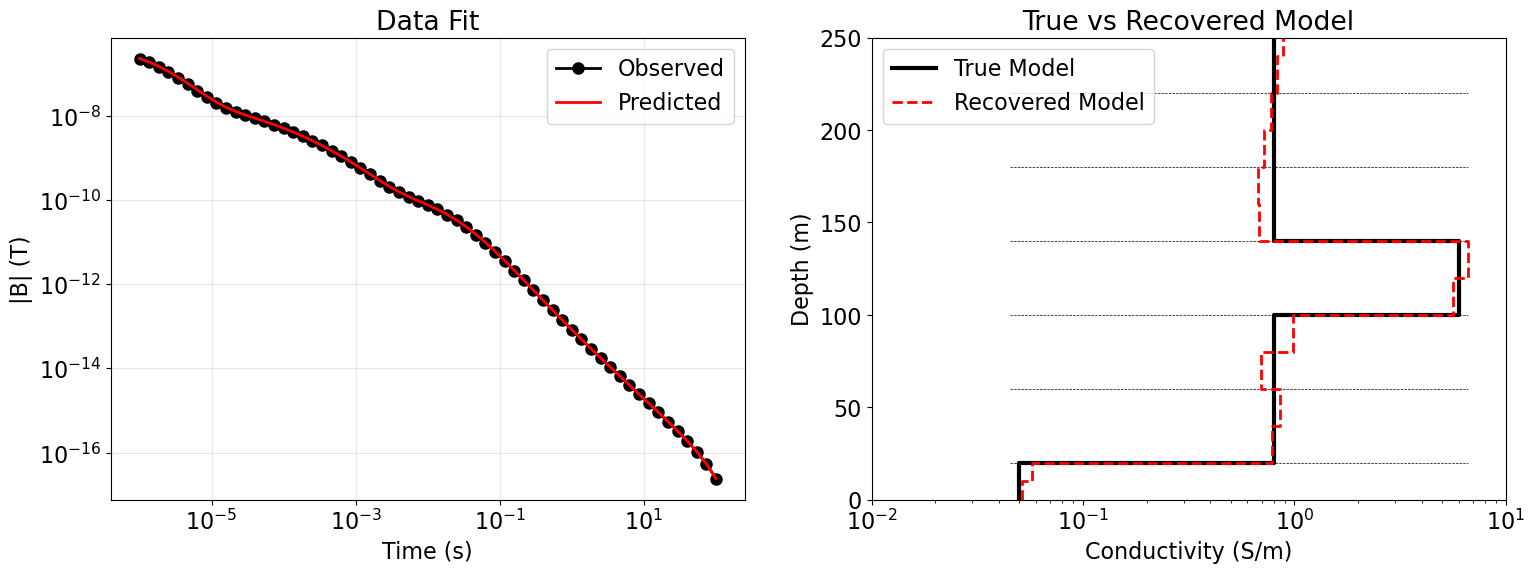

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.time_domain as tdem

from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})
data_filename = "six_layer_model.txt"
dobs = np.loadtxt(str(data_filename), skiprows=1)

times = dobs[:, 0]
dobs = mkvc(dobs[:, -1])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "k-o", lw=3)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Observed Data")
plt.show()
source_location = np.array([0.0, 0.0, 0.5])
source_orientation = "z"
source_current = 10.0  
source_radius = 15.0
receiver_location = np.array([0.0, 0.0, 0.5])
receiver_orientation = "z"
receiver_list = [
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
]
waveform = tdem.sources.StepOffWaveform()
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]
survey = tdem.Survey(source_list)
uncertainties = 0.02 * np.abs(dobs)

data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

inv_thicknesses = np.r_[
    10, 10,                    # 0-20m: 3 layers (first true layer)
    20, 20 ,             # 20-60m: 4 layers (second true layer)
    20, 20,           # 60-100m: 4 layers (third true layer)
    20,20,        # 100-140m: 4 layers (fourth true layer - conductive)
    20,20,              # 140-180m: 4 layers (fifth true layer)
    20, 20, 20, 20               # 180-260m: 4 layers (sixth true layer basement)
]

mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")
starting_conductivity = 0.5 
starting_model = np.log(starting_conductivity * np.ones(mesh.nC))

print(f"Starting conductivity: {starting_conductivity} S/m")
model_mapping = maps.ExpMap()

simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
reg_map = maps.IdentityMap(nP=mesh.nC)

reg = regularization.Sparse(
    mesh, 
    mapping=reg_map,
    alpha_s=1.0,     
    alpha_x=1,      
)
reg.norms = [0, 2]
reg.mref = starting_model
opt = optimization.ProjectedGNCG(
    maxIter=40,       
    maxIterLS=100,
    maxIterCG=30,
    tolCG=1e-3
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
update_jacobi = directives.UpdatePreconditioner()
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=30, minGNiter=1, coolEpsFact=1.5, update_beta=True
)
sensitivity_weights = directives.UpdateSensitivityWeights()
target_misfit = directives.TargetMisfit(chifact=1.0)
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_iteration,
    update_IRLS ,
    update_jacobi,
]
inv = inversion.BaseInversion(inv_prob, directives_list)

recovered_model = inv.run(starting_model)
recovered_conductivity = np.exp(recovered_model)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax1 = axes[0]
dpred = simulation.dpred(recovered_model)
ax1.loglog(times, np.abs(dobs), 'ko-', lw=2, label='Observed')
ax1.loglog(times, np.abs(dpred), 'r-', lw=2, label='Predicted')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("|B| (T)")
ax1.set_title("Data Fit")
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)
ax2 = axes[1]
true_thicknesses = np.array([20.0, 40.0, 40.0, 40.0, 40.0])
true_sigma = np.array([0.05, 0.8, 0.8, 6.0, 0.8, 0.8])
plot_1d_layer_model(
    true_thicknesses, true_sigma, ax=ax2, 
    show_layers=True, color='k', label='True Model', linewidth=3
)
plot_1d_layer_model(
    inv_thicknesses, recovered_conductivity, ax=ax2,
    show_layers=False, color='r', linestyle='--', label='Recovered Model', linewidth=2
)
ax2.set_xlabel("Conductivity (S/m)")
ax2.set_ylabel("Depth (m)")
ax2.set_title("True vs Recovered Model")
ax2.legend()
ax2.set_xlim([0.01, 10])
ax2.set_ylim([0, 250])
plt.show()
print("\n" + "="*50)

# Scenario 2: Least Squares Inversion without Reference Model

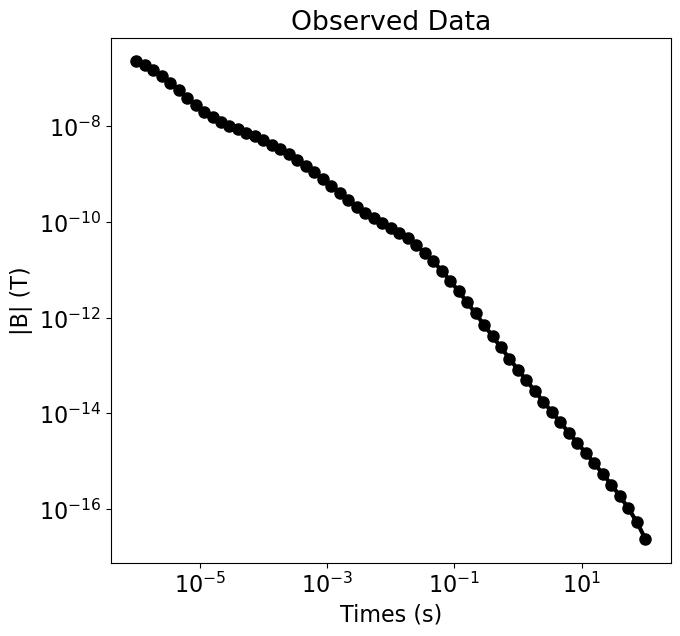

Starting conductivity: 0.5 S/m

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        


C:\Users\sadra\AppData\Local\Temp\ipykernel_5908\29834002.py:91: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  reg.mref = starting_model


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.08e+07  7.60e+05  0.00e+00  7.60e+05    1.30e+06      0              
   1  1.08e+07  3.97e+05  1.00e-03  4.08e+05    5.71e+05      0              
   2  5.40e+06  6.34e+04  7.68e-04  6.75e+04    1.19e+05      0   Skip BFGS  
   3  5.40e+06  1.82e+04  9.40e-04  2.33e+04    3.02e+04      0   Skip BFGS  
   4  2.70e+06  1.13e+04  9.27e-04  1.38e+04    9.59e+03      0   Skip BFGS  
   5  2.70e+06  9.02e+03  1.37e-03  1.27e+04    5.40e+03      0   Skip BFGS  
   6  1.35e+06  8.24e+03  1.47e-03  1.02e+04    3.01e+03      0   Skip BFGS  
   7  1.35e+06  6.57e+03  2.28e-03  9.64e+03    1.66e+03      0              
   8  6.75e+05  6.09e+03  2.51e-03  7.79e+03    2.67e+03      0              
   9  6.75e+05  4.46e+03

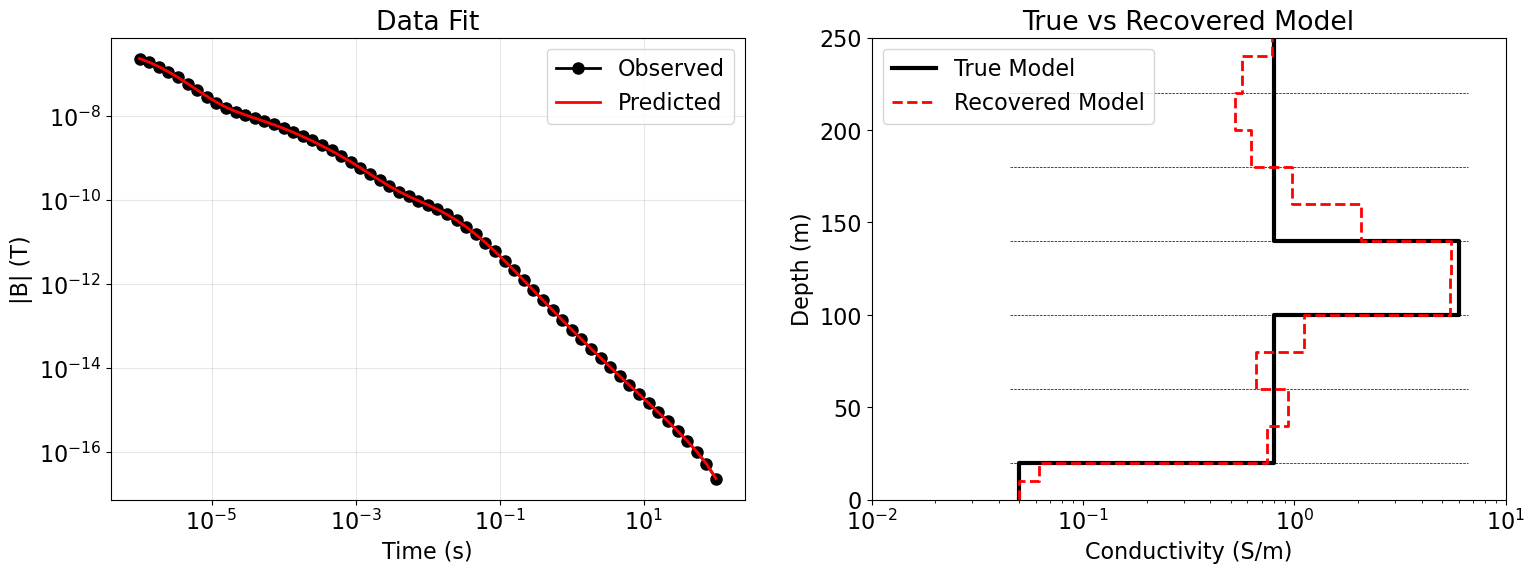

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.time_domain as tdem

from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})
data_filename = "six_layer_model.txt"
dobs = np.loadtxt(str(data_filename), skiprows=1)

times = dobs[:, 0]
dobs = mkvc(dobs[:, -1])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "k-o", lw=3)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Observed Data")
plt.show()
source_location = np.array([0.0, 0.0, 0.5])
source_orientation = "z"
source_current = 10.0  
source_radius = 15.0
receiver_location = np.array([0.0, 0.0, 0.5])
receiver_orientation = "z"
receiver_list = [
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
]
waveform = tdem.sources.StepOffWaveform()
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]
survey = tdem.Survey(source_list)
uncertainties = 0.02 * np.abs(dobs)

data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

inv_thicknesses = np.r_[
    10, 10,                    # 0-20m: 3 layers (first true layer)
    20, 20 ,             # 20-60m: 4 layers (second true layer)
    20, 20,           # 60-100m: 4 layers (third true layer)
    20,20,        # 100-140m: 4 layers (fourth true layer - conductive)
    20,20,              # 140-180m: 4 layers (fifth true layer)
    20, 20, 20, 20               # 180-260m: 4 layers (sixth true layer basement)
]

mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")
starting_conductivity = 0.5 
starting_model = np.log(starting_conductivity * np.ones(mesh.nC))

print(f"Starting conductivity: {starting_conductivity} S/m")
model_mapping = maps.ExpMap()

simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
reg_map = maps.IdentityMap(nP=mesh.nC)

reg = regularization.WeightedLeastSquares(
    mesh, 
    mapping=reg_map,
    alpha_s=0.00000000000001,      # Smallness weight
    alpha_x=1,      # Smoothness weight (allow some variation)
)
# Set reference model
reg.mref = starting_model
opt = optimization.ProjectedGNCG(
    maxIter=20,      
    maxIterLS=100,
    maxIterCG=30,
    tolCG=1e-3
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
update_jacobi = directives.UpdatePreconditioner()
sensitivity_weights = directives.UpdateSensitivityWeights()
target_misfit = directives.TargetMisfit(chifact=1.0)
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
]
inv = inversion.BaseInversion(inv_prob, directives_list)

recovered_model2 = inv.run(starting_model)
recovered_conductivity = np.exp(recovered_model2)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax1 = axes[0]
dpred = simulation.dpred(recovered_model2)
ax1.loglog(times, np.abs(dobs), 'ko-', lw=2, label='Observed')
ax1.loglog(times, np.abs(dpred), 'r-', lw=2, label='Predicted')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("|B| (T)")
ax1.set_title("Data Fit")
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Plot 2: True vs Recovered Model
ax2 = axes[1]

# True model
true_thicknesses = np.array([20.0, 40.0, 40.0, 40.0, 40.0])
true_sigma = np.array([0.05, 0.8, 0.8, 6.0, 0.8, 0.8])

plot_1d_layer_model(
    true_thicknesses, true_sigma, ax=ax2, 
    show_layers=True, color='k', label='True Model', linewidth=3
)

# Recovered model
plot_1d_layer_model(
    inv_thicknesses, recovered_conductivity, ax=ax2,
    show_layers=False, color='r', linestyle='--', label='Recovered Model', linewidth=2
)
ax2.set_xlabel("Conductivity (S/m)")
ax2.set_ylabel("Depth (m)")
ax2.set_title("True vs Recovered Model")
ax2.legend()
ax2.set_xlim([0.01, 10])
ax2.set_ylim([0, 250])
plt.show()
print("\n" + "="*50)

# Scenario 3:Least Squares Inversion with Reference Model

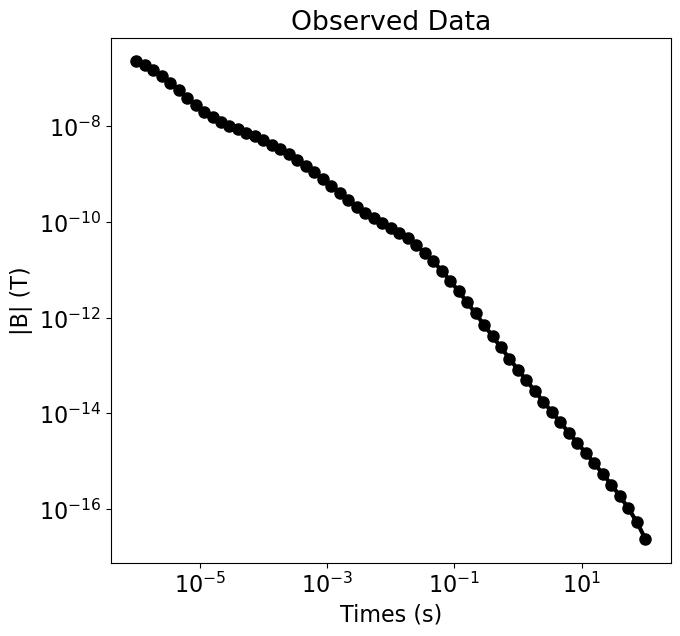

Starting conductivity: 0.5 S/m

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        


C:\Users\sadra\AppData\Local\Temp\ipykernel_5908\711707163.py:87: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  reg.mref = starting_model


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.27e+05  7.60e+05  0.00e+00  7.60e+05    1.30e+06      0              
   1  1.27e+05  3.03e+05  1.30e+00  4.68e+05    8.94e+04      0              
   2  6.33e+04  3.25e+05  1.10e+00  3.95e+05    3.17e+05      0              
   3  6.33e+04  2.00e+05  2.59e+00  3.63e+05    6.01e+04      0              
   4  3.16e+04  2.20e+05  2.24e+00  2.91e+05    2.27e+05      0              
   5  3.16e+04  1.20e+05  4.59e+00  2.65e+05    4.69e+04      0              
   6  1.58e+04  1.37e+05  4.00e+00  2.00e+05    1.58e+05      0              
   7  1.58e+04  6.44e+04  7.32e+00  1.80e+05    3.32e+04      0              
   8  7.91e+03  7.87e+04  6.35e+00  1.29e+05    1.06e+05      0              
   9  7.91e+03  3.40e+04

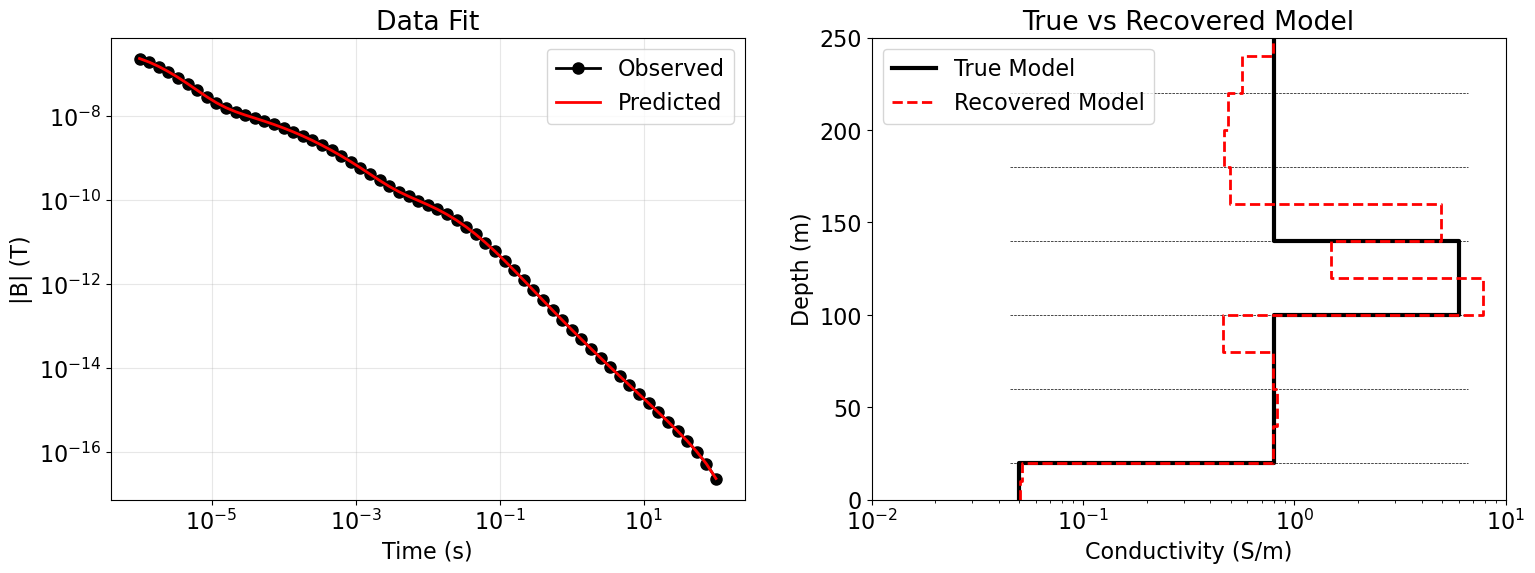

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.time_domain as tdem

from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})
data_filename = "six_layer_model.txt"
dobs = np.loadtxt(str(data_filename), skiprows=1)
times = dobs[:, 0]
dobs = mkvc(dobs[:, -1])
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "k-o", lw=3)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Observed Data")
plt.show()
source_location = np.array([0.0, 0.0, 0.5])
source_orientation = "z"
source_current = 10.0  
source_radius = 15.0
receiver_location = np.array([0.0, 0.0, 0.5])
receiver_orientation = "z"
receiver_list = [
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
]
waveform = tdem.sources.StepOffWaveform()
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]
survey = tdem.Survey(source_list)
uncertainties = 0.02 * np.abs(dobs)

data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

inv_thicknesses = np.r_[
    10, 10,                    # 0-20m: 3 layers (first true layer)
    20, 20 ,             # 20-60m: 4 layers (second true layer)
    20, 20,           # 60-100m: 4 layers (third true layer)
    20,20,        # 100-140m: 4 layers (fourth true layer - conductive)
    20,20,              # 140-180m: 4 layers (fifth true layer)
    20, 20, 20, 20               # 180-260m: 4 layers (sixth true layer basement)
]

mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")
starting_conductivity = 0.5 
starting_model = np.log(starting_conductivity * np.ones(mesh.nC))

print(f"Starting conductivity: {starting_conductivity} S/m")
model_mapping = maps.ExpMap()
simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
reg_map = maps.IdentityMap(nP=mesh.nC)

reg = regularization.WeightedLeastSquares(
    mesh, 
    mapping=reg_map,
    alpha_s=1,     
    alpha_x=1,     
)
# Set reference model
reg.mref = starting_model
opt = optimization.ProjectedGNCG(
    maxIter=30,      
    maxIterLS=100,
    maxIterCG=30,
    tolCG=1e-3
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
update_jacobi = directives.UpdatePreconditioner()
sensitivity_weights = directives.UpdateSensitivityWeights()
target_misfit = directives.TargetMisfit(chifact=1.0)
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
]
inv = inversion.BaseInversion(inv_prob, directives_list)

recovered_model = inv.run(starting_model)
recovered_conductivity = np.exp(recovered_model)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax1 = axes[0]
dpred = simulation.dpred(recovered_model)
ax1.loglog(times, np.abs(dobs), 'ko-', lw=2, label='Observed')
ax1.loglog(times, np.abs(dpred), 'r-', lw=2, label='Predicted')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("|B| (T)")
ax1.set_title("Data Fit")
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Plot 2: True vs Recovered Model
ax2 = axes[1]

# True model
true_thicknesses = np.array([20.0, 40.0, 40.0, 40.0, 40.0])
true_sigma = np.array([0.05, 0.8, 0.8, 6.0, 0.8, 0.8])

plot_1d_layer_model(
    true_thicknesses, true_sigma, ax=ax2, 
    show_layers=True, color='k', label='True Model', linewidth=3
)

# Recovered model
plot_1d_layer_model(
    inv_thicknesses, recovered_conductivity, ax=ax2,
    show_layers=False, color='r', linestyle='--', label='Recovered Model', linewidth=2
)
ax2.set_xlabel("Conductivity (S/m)")
ax2.set_ylabel("Depth (m)")
ax2.set_title("True vs Recovered Model")
ax2.legend()
ax2.set_xlim([0.01, 10])
ax2.set_ylim([0, 250])
plt.show()
print("\n" + "="*50)

#  Scenario 4: L2 Model as the Reference Model for Sparse Inversion (reference_model_in_smooth=False)

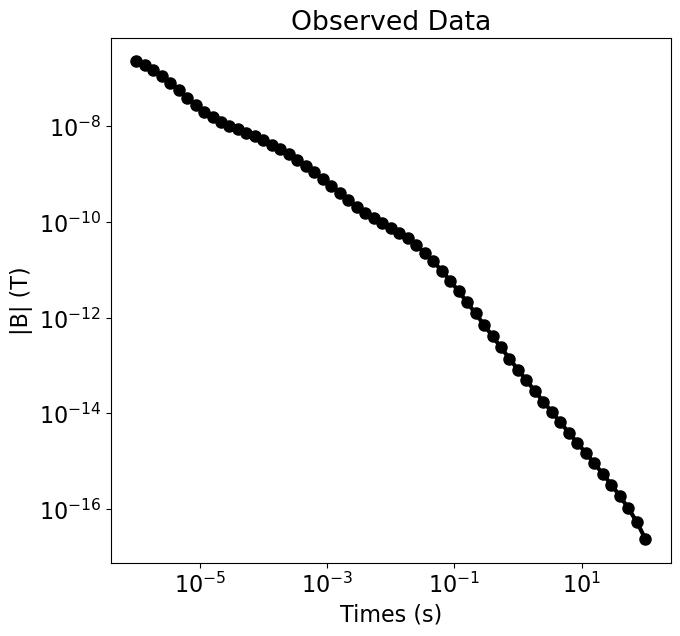

C:\Users\sadra\AppData\Local\Temp\ipykernel_5908\2193218806.py:91: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  reg.mref = starting_model



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.92e+04  1.65e+01  7.33e-02  3.63e+03    2.59e+03      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 0.016512171005128806
   1  1.23e+04  1.94e+01  7.31e-02  9.19e+02    1.07e+03      0              
   2  1.15e+04  1.77e+01  7.30e-02  8.54e+02    1.98e+02      0              
   3  1.07e+04  1.77e+01  7.29e-02  7.95e+02    2.51e+02      0   Skip BFGS  
   4  9.79e+03  1.83e+01  7.27e-02  7.29e+02    3.63e+02      0              
 

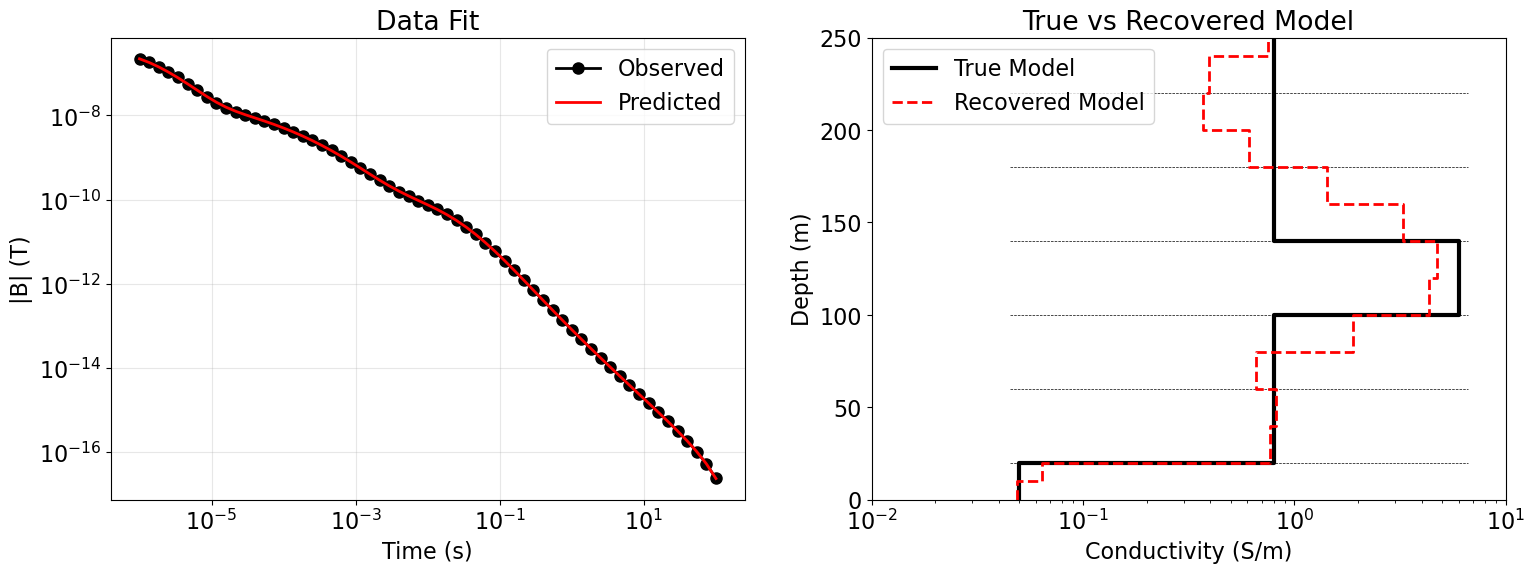

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.time_domain as tdem

from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})
data_filename = "six_layer_model.txt"
dobs = np.loadtxt(str(data_filename), skiprows=1)

times = dobs[:, 0]
dobs = mkvc(dobs[:, -1])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "k-o", lw=3)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Observed Data")
plt.show()
source_location = np.array([0.0, 0.0, 0.5])
source_orientation = "z"
source_current = 10.0  
source_radius = 15.0
receiver_location = np.array([0.0, 0.0, 0.5])
receiver_orientation = "z"
receiver_list = [
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
]
waveform = tdem.sources.StepOffWaveform()
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]
survey = tdem.Survey(source_list)
uncertainties = 0.02 * np.abs(dobs)

data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

inv_thicknesses = np.r_[
    10, 10,                    # 0-20m: 3 layers (first true layer)
    20, 20 ,             # 20-60m: 4 layers (second true layer)
    20, 20,           # 60-100m: 4 layers (third true layer)
    20,20,        # 100-140m: 4 layers (fourth true layer - conductive)
    20,20,              # 140-180m: 4 layers (fifth true layer)
    20, 20, 20, 20               # 180-260m: 4 layers (sixth true layer basement)
]

mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")
#starting_conductivity = 0.5 
starting_model = recovered_model2
model_mapping = maps.ExpMap()

simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
reg_map = maps.IdentityMap(nP=mesh.nC)

reg = regularization.Sparse(
    mesh, 
    mapping=reg_map,
    alpha_s= 1,      # Smallness weight
    alpha_x=1,  
    reference_model_in_smooth=False
)
reg.norms = [0, 2]
# Set reference model
reg.mref = starting_model
opt = optimization.ProjectedGNCG(
    maxIter=200,        # Increased iterations
    maxIterLS=100,
    maxIterCG=10,
    tolCG=1e-3
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
update_jacobi = directives.UpdatePreconditioner()
update_IRLS = directives.Update_IRLS(
    f_min_change=1e-2, max_irls_iterations=120, minGNiter=1, coolEpsFact=1.5, update_beta=True
)
sensitivity_weights = directives.UpdateSensitivityWeights()
target_misfit = directives.TargetMisfit(chifact=1.0)
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_IRLS ,
    update_jacobi,
]
inv = inversion.BaseInversion(inv_prob, directives_list)

recovered_model3 = inv.run(starting_model)
recovered_conductivity3 = np.exp(recovered_model3)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax1 = axes[0]
dpred = simulation.dpred(recovered_model3)
ax1.loglog(times, np.abs(dobs), 'ko-', lw=2, label='Observed')
ax1.loglog(times, np.abs(dpred), 'r-', lw=2, label='Predicted')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("|B| (T)")
ax1.set_title("Data Fit")
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Plot 2: True vs Recovered Model
ax2 = axes[1]

# True model
true_thicknesses = np.array([20.0, 40.0, 40.0, 40.0, 40.0])
true_sigma = np.array([0.05, 0.8, 0.8, 6.0, 0.8, 0.8])

plot_1d_layer_model(
    true_thicknesses, true_sigma, ax=ax2, 
    show_layers=True, color='k', label='True Model', linewidth=3
)

# Recovered model
plot_1d_layer_model(
    inv_thicknesses, recovered_conductivity3, ax=ax2,
    show_layers=False, color='r', linestyle='--', label='Recovered Model', linewidth=2
)
ax2.set_xlabel("Conductivity (S/m)")
ax2.set_ylabel("Depth (m)")
ax2.set_title("True vs Recovered Model")
ax2.legend()
ax2.set_xlim([0.01, 10])
ax2.set_ylim([0, 250])
plt.show()
print("\n" + "="*50)

# Scenario 4: L2 Model as the Reference Model for Sparse Inversion (reference_model_in_smooth= True)

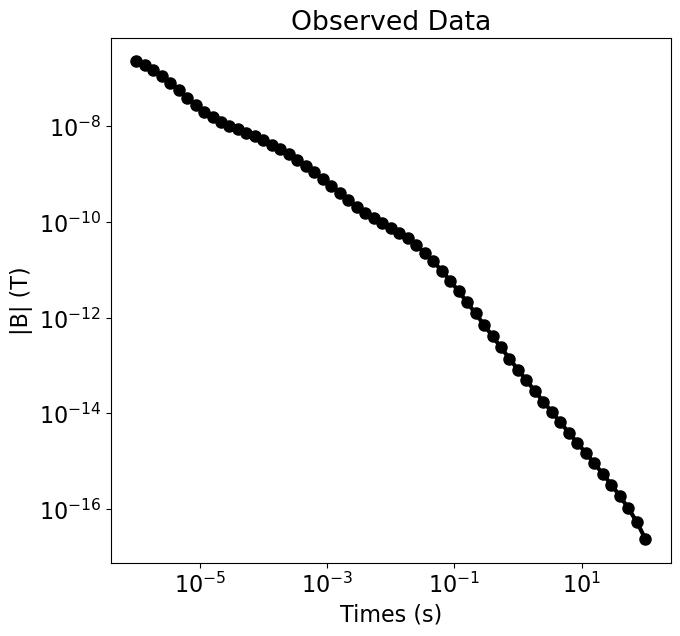

C:\Users\sadra\AppData\Local\Temp\ipykernel_5908\2959825621.py:90: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  reg.mref = starting_model



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.93e+04  1.65e+01  0.00e+00  1.65e+01    4.12e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 0.0008593340114589343
   1  1.23e+04  1.60e+01  5.17e-06  1.61e+01    2.84e+02      0              
   2  1.24e+04  1.50e+01  2.30e-05  1.53e+01    2.23e+02      0   Skip BFGS  
   3  1.33e+04  1.33e+01  4.69e-05  1.39e+01    2.20e+02      0   Skip BFGS  
   4  1.51e+04  1.21e+01  6.16e-05  1.30e+01    3.15e+02      0   Skip BFGS  


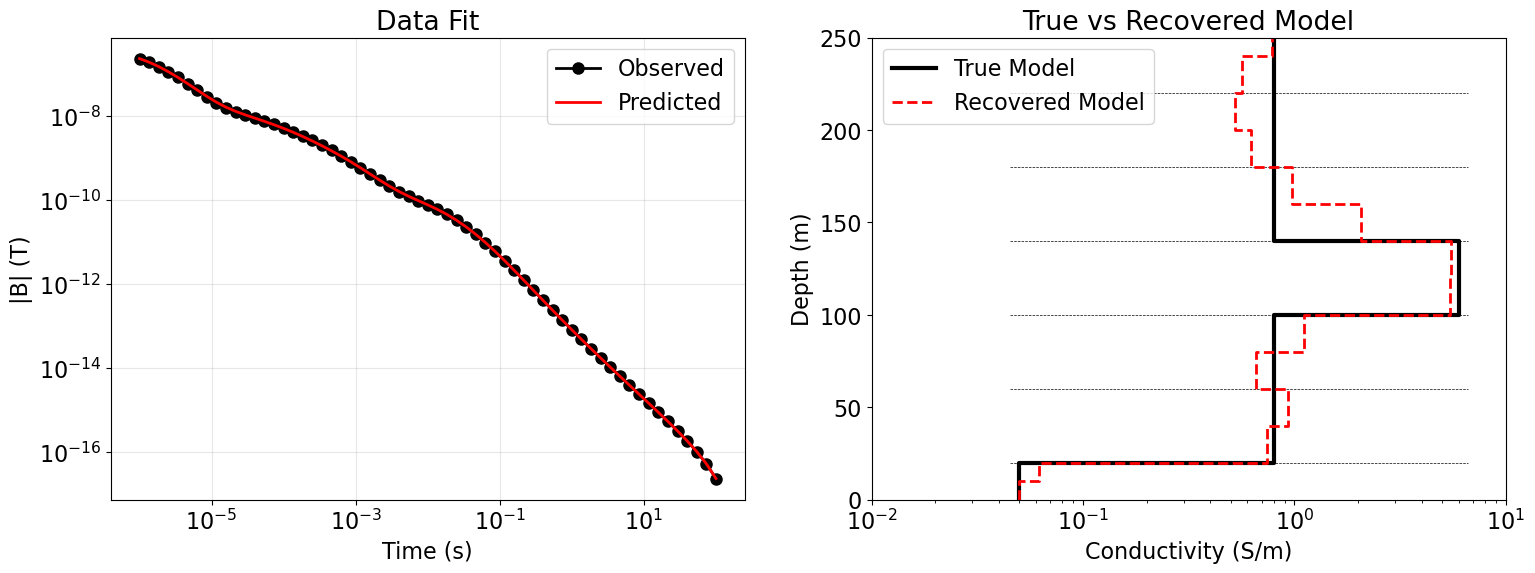

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.time_domain as tdem

from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})
data_filename = "six_layer_model.txt"
dobs = np.loadtxt(str(data_filename), skiprows=1)

times = dobs[:, 0]
dobs = mkvc(dobs[:, -1])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "k-o", lw=3)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Observed Data")
plt.show()
source_location = np.array([0.0, 0.0, 0.5])
source_orientation = "z"
source_current = 10.0  
source_radius = 15.0
receiver_location = np.array([0.0, 0.0, 0.5])
receiver_orientation = "z"
receiver_list = [
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
]
waveform = tdem.sources.StepOffWaveform()
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]
survey = tdem.Survey(source_list)
uncertainties = 0.02 * np.abs(dobs)

data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

inv_thicknesses = np.r_[
    10, 10,                    # 0-20m: 3 layers (first true layer)
    20, 20 ,             # 20-60m: 4 layers (second true layer)
    20, 20,           # 60-100m: 4 layers (third true layer)
    20,20,        # 100-140m: 4 layers (fourth true layer - conductive)
    20,20,              # 140-180m: 4 layers (fifth true layer)
    20, 20, 20, 20               # 180-260m: 4 layers (sixth true layer basement)
]

mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")
#starting_conductivity = 0.5 
starting_model = recovered_model2
model_mapping = maps.ExpMap()

simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
reg_map = maps.IdentityMap(nP=mesh.nC)

reg = regularization.Sparse(
    mesh, 
    mapping=reg_map,
    alpha_s= 1,      # Smallness weight
    alpha_x=1,  
    reference_model_in_smooth= True,
)
reg.norms = [0, 2]
reg.mref = starting_model
opt = optimization.ProjectedGNCG(
    maxIter=200,        
    maxIterLS=100,
    maxIterCG=30,
    tolCG=1e-3
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
update_jacobi = directives.UpdatePreconditioner()
update_IRLS = directives.Update_IRLS(
    f_min_change=1e-2,max_irls_iterations=120, minGNiter=1, coolEpsFact=1.5, update_beta=True
)
sensitivity_weights = directives.UpdateSensitivityWeights()
target_misfit = directives.TargetMisfit(chifact=1.0)
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_IRLS ,
    update_jacobi,
]
inv = inversion.BaseInversion(inv_prob, directives_list)

recovered_model3 = inv.run(starting_model)
recovered_conductivity3 = np.exp(recovered_model3)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax1 = axes[0]
dpred = simulation.dpred(recovered_model3)
ax1.loglog(times, np.abs(dobs), 'ko-', lw=2, label='Observed')
ax1.loglog(times, np.abs(dpred), 'r-', lw=2, label='Predicted')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("|B| (T)")
ax1.set_title("Data Fit")
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Plot 2: True vs Recovered Model
ax2 = axes[1]

# True model
true_thicknesses = np.array([20.0, 40.0, 40.0, 40.0, 40.0])
true_sigma = np.array([0.05, 0.8, 0.8, 6.0, 0.8, 0.8])

plot_1d_layer_model(
    true_thicknesses, true_sigma, ax=ax2, 
    show_layers=True, color='k', label='True Model', linewidth=3
)

# Recovered model
plot_1d_layer_model(
    inv_thicknesses, recovered_conductivity3, ax=ax2,
    show_layers=False, color='r', linestyle='--', label='Recovered Model', linewidth=2
)
ax2.set_xlabel("Conductivity (S/m)")
ax2.set_ylabel("Depth (m)")
ax2.set_title("True vs Recovered Model")
ax2.legend()
ax2.set_xlim([0.01, 10])
ax2.set_ylim([0, 250])
plt.show()
print("\n" + "="*50)